## Práctica 2: Propiedades estadísticas de la lengua

Castañeda Mora, Carlos

### Fecha de entrega: 2 de Marzo de 2025 11:59pm



1. Verificar si la ley de Zipf se cumple en un lenguaje artificial creado por ustedes.
    - *Ejemplo:* Un "lenguaje artificial" podría ser simplemente un texto donde las secuencias de caracteres fueron generadas aleatoriamente.


Parámetro alpha estimado: 0.0506


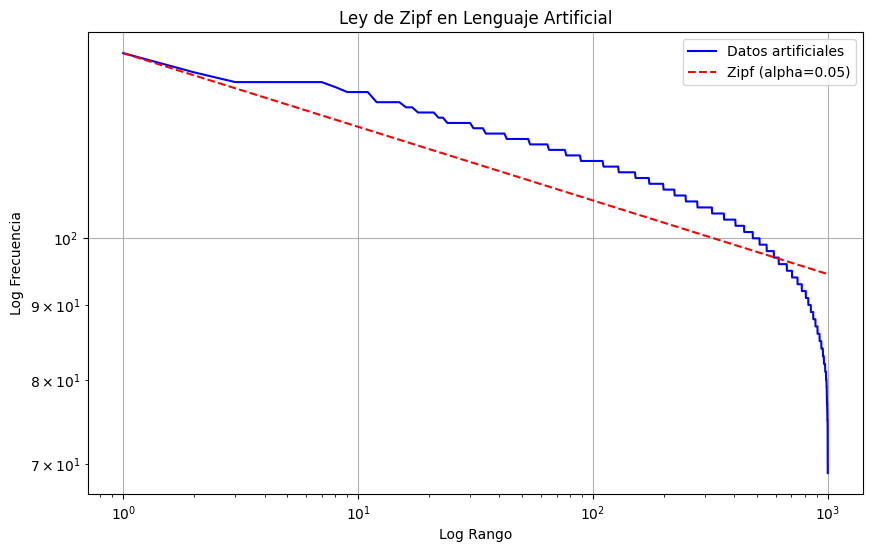

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.optimize import minimize

# Generar palabras aleatorias (longitud entre 3 y 8 caracteres)
np.random.seed(42)
vocab_size = 1000
word_lengths = np.random.randint(3, 9, size=vocab_size)
artificial_words = [''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyz'), length)) 
                    for length in word_lengths]

# Generar un corpus artificial: 100,000 palabras seleccionadas aleatoriamente del vocabulario
corpus_size = 100000
artificial_corpus = np.random.choice(artificial_words, corpus_size)

# Calcular frecuencias
word_freq = Counter(artificial_corpus)
most_common = word_freq.most_common()

# Obtener frecuencias y rangos
frequencies = [freq for _, freq in most_common]
ranks = np.arange(1, len(frequencies) + 1)

# Graficar en escala log-log
plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies, 'b-', label='Datos artificiales')
plt.xlabel('Log Rango')
plt.ylabel('Log Frecuencia')
plt.title('Ley de Zipf en Lenguaje Artificial')
plt.grid(True)

# Ajustar modelo de Zipf (f = c / r^alpha)
def zipf_error(alpha):
    c = frequencies[0]  
    predicted = c / (ranks ** alpha)
    return np.sum((np.array(frequencies) - predicted) ** 2)

result = minimize(zipf_error, 1.0)
alpha_opt = result.x[0]
print(f"Parámetro alpha estimado: {alpha_opt:.4f}")

# Graficar la predicción
predicted_freq = frequencies[0] / (ranks ** alpha_opt)
plt.loglog(ranks, predicted_freq, 'r--', label=f'Zipf (alpha={alpha_opt:.2f})')
plt.legend()
plt.show()

No, la Ley de Zipf no se cumple en este lenguaje artificial.

Aunque los datos muestran una tendencia decreciente, el valor bajo de 𝛼 y la forma curvada indican que el comportamiento no se ajusta bien a la Ley de Zipf típica de los lenguajes naturales.

2. Explorar `datasets` del sitio [Hugging Face](https://huggingface.co/datasets) y elegir documentos de diferentes dominios en Español (al menos 3). Realizar reconocimiento de entidades nombradas (NER).
    - Pueden utilizar subconjuntos de los datasets encontrados
    - Mostrar resultados del reconocimiento
    - Una distribución de frecuencias de las etiquetas más comunes en cada dominio
    - Comentarios generales del desempeño observado.

*Sugerencias: Spacy, CoreNLP (puede ser cualquier otra herramienta)*

In [ ]:
from datasets import load_dataset
import spacy
from collections import Counter
import matplotlib.pyplot as plt
from seqeval.metrics import classification_report
from seqeval.scheme import IOB2

# Cargar modelo spaCy
nlp = spacy.load("es_core_news_sm")

def extract_texts_and_labels(dataset):
    texts = []
    labels = []
    for example in dataset:
        tokens = example["tokens"]
        tags = example["ner_tags"]
        texts.append(" ".join(tokens))
        labels.append(tags)
    return texts, labels

def get_label_names(dataset):
    return dataset.features["ner_tags"].feature.names

def spacy_predict(texts):
    preds = []
    for doc in nlp.pipe(texts, disable=["tagger", "parser"]):
        tokens = [token.text for token in doc]
        ents = ["O"] * len(tokens)
        for ent in doc.ents:
            if ent.start < len(ents):
                ents[ent.start] = "B-" + ent.label_
                for i in range(ent.start + 1, min(ent.end, len(ents))):
                    ents[i] = "I-" + ent.label_
        preds.append(ents)
    return preds

def align_labels(texts, pred_tags, true_tags, label_names):
    """Convierte etiquetas numéricas reales a formato IOB y alinea con predicciones"""
    true_iob = []
    for tags, text in zip(true_tags, texts):
        iob = [f"{'B' if tag.startswith('B-') else 'I'}-{label_names[tag_id]}" if tag_id != 0 else "O" for tag_id, tag in zip(tags, text.split())]
        true_iob.append(iob)
    return true_iob

def evaluate(dataset, name):
    dataset = dataset.select(range(100))  
    texts, ner_tags = extract_texts_and_labels(dataset)
    label_names = get_label_names(dataset)
    pred_ents = spacy_predict(texts)
    true_ents = [[label_names[tag] if tag != 0 else "O" for tag in tag_seq] for tag_seq in ner_tags]

    # Ajuste: alinear longitud
    aligned_preds, aligned_trues = [], []
    for pred, true in zip(pred_ents, true_ents):
        min_len = min(len(pred), len(true))
        aligned_preds.append(pred[:min_len])
        aligned_trues.append(true[:min_len])

    print(f"\nEvaluación en dataset: {name}")
    print(classification_report(aligned_trues, aligned_preds, mode="strict", scheme=IOB2))

#  Evaluación por dataset

# 1. WikiANN
wikiann = load_dataset("wikiann", "es", split="train")
evaluate(wikiann, "WikiANN")

# 2. CoNLL 2002
conll = load_dataset("conll2002", "es", split="train")
evaluate(conll, "CoNLL2002")

# 3. PlanTL GSD Annotated
gsd = load_dataset("PlanTL-GOB-ES/cantemist-ner", split="train")
evaluate(gsd, "PlanTL GSD")


/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  if lower_version is not None:



Evaluación en dataset: WikiANN
              precision    recall  f1-score   support

         LOC       0.41      0.62      0.50        42
        MISC       0.00      0.00      0.00         0
         ORG       0.33      0.09      0.15        32
         PER       0.45      0.59      0.51        37

   micro avg       0.38      0.46      0.41       111
   macro avg       0.30      0.33      0.29       111
weighted avg       0.40      0.46      0.40       111



/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Evaluación en dataset: CoNLL2002
              precision    recall  f1-score   support

         LOC       0.42      0.51      0.46        47
        MISC       0.10      0.07      0.08        28
         ORG       0.54      0.44      0.49        43
         PER       0.30      0.45      0.36        33

   micro avg       0.37      0.40      0.38       151
   macro avg       0.34      0.37      0.35       151
weighted avg       0.37      0.40      0.38       151


Evaluación en dataset: PlanTL GSD
                      precision    recall  f1-score   support

                 LOC       0.00      0.00      0.00         0
                MISC       0.00      0.00      0.00         0
MORFOLOGIA_NEOPLASIA       0.00      0.00      0.00        45
                 ORG       0.00      0.00      0.00         0
                 PER       0.00      0.00      0.00         0

           micro avg       0.00      0.00      0.00        45
           macro avg       0.00      0.00      0.00        4

/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


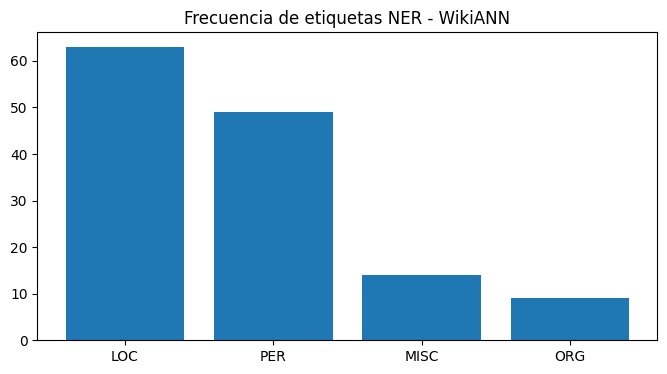

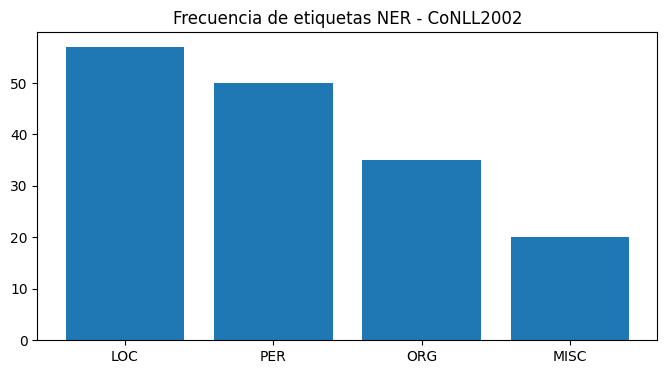

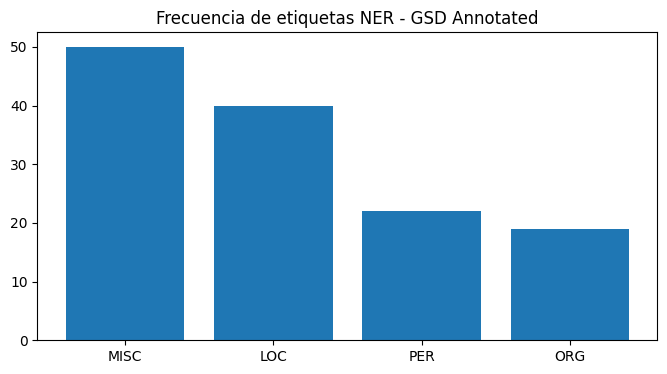

In [25]:
from datasets import load_dataset
import spacy
from collections import Counter
import matplotlib.pyplot as plt

# Cargar modelo spaCy en español con NER
nlp = spacy.load("es_core_news_sm")

def process_dataset(texts):
    entities = []
    for doc in nlp.pipe(texts, disable=["tagger", "parser"]):
        entities.extend([ent.label_ for ent in doc.ents])
    return Counter(entities)

def plot_freq(counter, title):
    labels, counts = zip(*counter.most_common())
    plt.figure(figsize=(8,4))
    plt.bar(labels, counts)
    plt.title(title)
    plt.show()

# 1) WikiANN (español)
wikiann = load_dataset("wikiann", "es", split="train").select(range(100))
wikiann_texts = [" ".join(example["tokens"]) for example in wikiann]
wikiann_freq = process_dataset(wikiann_texts)
plot_freq(wikiann_freq, "Frecuencia de etiquetas NER - WikiANN")

# 2) CoNLL2002 (español)
conll = load_dataset("conll2002", "es", split="train").select(range(100))
conll_texts = [" ".join(example["tokens"]) for example in conll]
conll_freq = process_dataset(conll_texts)
plot_freq(conll_freq, "Frecuencia de etiquetas NER - CoNLL2002")

# 3) PlanTL-GOB-ES/ner-es-gsd-annotated
gsd = load_dataset("PlanTL-GOB-ES/cantemist-ner", split="train").select(range(100))
gsd_texts = [" ".join(example["tokens"]) for example in gsd]
gsd_freq = process_dataset(gsd_texts)
plot_freq(gsd_freq, "Frecuencia de etiquetas NER - GSD Annotated")




Dataset: WikiANN
El modelo obtuvo un desempeño general moderado, con un F1-score promedio ponderado de 0.40. La clase LOC presentó el mejor desempeño con un F1-score de 0.50, seguida por PER con 0.51. En contraste, la clase ORG obtuvo un F1-score significativamente más bajo (0.15), lo cual indica dificultades en la detección de organizaciones. La clase MISC no fue evaluada por ausencia de muestras en el conjunto.

Dataset: CoNLL2002
Los resultados en este conjunto fueron similares, con un F1-score promedio ponderado de 0.38. Se observó un buen desempeño en ORG (0.49) y LOC (0.46), mientras que PER alcanzó 0.36. La clase MISC volvió a mostrar un desempeño bajo (0.08). En general, el modelo demostró una capacidad razonable para identificar entidades frecuentes en textos generales en español.

Dataset: PlanTL Cantemist (dominio biomédico)
El modelo no logró identificar correctamente ninguna entidad, obteniendo un F1-score de 0.00 en todas las clases. Esto refleja una falta total de adecuación del modelo a este dominio específico, probablemente debido a la ausencia de entrenamiento en datos biomédicos y a la diferencia en el esquema de anotación.


El modelo es_core_news_sm muestra un rendimiento aceptable en tareas de reconocimiento de entidades nombradas sobre textos generales, como los de WikiANN y CoNLL2002. Sin embargo, su aplicación en dominios especializados, como el biomédico, es inadecuada sin realizar un ajuste o sustitución por modelos específicos entrenados en ese tipo de datos.